# Predicción de Calidad de Café mediante Machine Learning

## Resumen Ejecutivo

Este proyecto desarrolla un modelo predictivo de regresión para estimar el puntaje de taza de café utilizando variables del proceso de producción y control de calidad. El objetivo es crear una herramienta que permita predecir la calidad sensorial antes del proceso de catación, optimizando recursos y mejorando el control de calidad en la producción cafetera.

### Objetivos del Proyecto:
- **Principal**: Predecir el puntaje de taza otorgado por catadores profesionales
- **Secundarios**: 
  - Identificar las variables más importantes para la calidad del café
  - Implementar validación temporal para prevenir memorización de datos
  - Desarrollar un sistema robusto de evaluación de modelos

### Metodología:
- Análisis exploratorio de datos de calidad, tostión y despachos
- Preprocesamiento y limpieza de datos con validación temporal
- Entrenamiento y comparación de múltiples algoritmos de ML
- Validación rigurosa con enfoque en generalización temporal

---

# 1. Configuración e Importación de Librerías

Para desarrollar el modelo predictivo, importamos las librerías esenciales para análisis de datos, visualización y machine learning.

In [61]:
# Importación de librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, Markdown

# Librerías de Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import shap

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


# 2. Carga y Exploración Inicial de Datos

Los datos del proyecto provienen de tres fuentes principales del proceso de producción del café:
- **Control de Calidad**: Contiene la variable objetivo (puntaje de taza) y características del grano
- **Control de Tostión**: Información sobre el proceso de tostado
- **Control de Despachos**: Datos de empaque y distribución

In [62]:
# Carga de datasets con codificación adecuada
df_calidad = pd.read_csv("Formato_de_Control_de Calidad_Cafe_de_Trillado.csv", encoding='latin1')
df_tostion = pd.read_csv("Formato_de_Tostion.csv", encoding='latin1')
df_despachos = pd.read_csv("Formato_de_Control_de_Despachos.csv", encoding='latin1')

# Conversión de columnas de fecha a datetime
print("Convirtiendo columnas de fecha a tipo datetime...")

# Dataset de Calidad
if 'FECHA' in df_calidad.columns:
    df_calidad['FECHA'] = pd.to_datetime(df_calidad['FECHA'], errors='coerce')
    print(f"  df_calidad['FECHA'] convertida a datetime")

# Dataset de Tostión  
if 'Fecha' in df_tostion.columns:
    df_tostion['Fecha'] = pd.to_datetime(df_tostion['Fecha'], errors='coerce')
    print(f"  df_tostion['Fecha'] convertida a datetime")

# Dataset de Despachos
if 'FECHA DE TUESTE' in df_despachos.columns:
    df_despachos['FECHA DE TUESTE'] = pd.to_datetime(df_despachos['FECHA DE TUESTE'], errors='coerce')
    print(f"  df_despachos['FECHA DE TUESTE'] convertida a datetime")
    
if 'FECHA DE EMPAQUE' in df_despachos.columns:
    df_despachos['FECHA DE EMPAQUE'] = pd.to_datetime(df_despachos['FECHA DE EMPAQUE'], errors='coerce')
    print(f"  df_despachos['FECHA DE EMPAQUE'] convertida a datetime")

print("Datos cargados y fechas convertidas exitosamente")

Convirtiendo columnas de fecha a tipo datetime...
  df_calidad['FECHA'] convertida a datetime
Datos cargados y fechas convertidas exitosamente


In [63]:
# Información básica de los datasets
datasets = {
    'Control de Calidad': df_calidad,
    'Control de Tostión': df_tostion, 
    'Control de Despachos': df_despachos
}

print("INFORMACIÓN GENERAL DE LOS DATASETS")
print("-" * 50)

info_datasets = []
for nombre, df in datasets.items():
    info = {
        'Dataset': nombre,
        'Filas': df.shape[0],
        'Columnas': df.shape[1],
        'Valores Nulos': df.isnull().sum().sum(),
        'Tipos de Datos': df.dtypes.value_counts().to_dict()
    }
    info_datasets.append(info)
    
    print(f"\n{nombre}:")
    print(f"   Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print(f"   Valores nulos: {df.isnull().sum().sum()}")
    print(f"   Tipos de datos: {dict(df.dtypes.value_counts())}")

print("Análisis inicial completado")

INFORMACIÓN GENERAL DE LOS DATASETS
--------------------------------------------------

Control de Calidad:
   Dimensiones: 108 filas x 14 columnas
   Valores nulos: 8
   Tipos de datos: {dtype('O'): np.int64(11), dtype('<M8[ns]'): np.int64(1), dtype('float64'): np.int64(1), dtype('int64'): np.int64(1)}

Control de Tostión:
   Dimensiones: 529 filas x 14 columnas
   Valores nulos: 510
   Tipos de datos: {dtype('O'): np.int64(11), dtype('float64'): np.int64(3)}

Control de Despachos:
   Dimensiones: 1611 filas x 12 columnas
   Valores nulos: 4952
   Tipos de datos: {dtype('O'): np.int64(8), dtype('float64'): np.int64(4)}
Análisis inicial completado


In [64]:
# Análisis de la variable objetivo (PUNTAJE)
print("ANÁLISIS DE LA VARIABLE OBJETIVO")
print("-" * 40)

# Examinar la columna PUNTAJE antes de limpieza
print("Estado original de PUNTAJE:")
print(f"  • Tipo de datos: {df_calidad['PUNTAJE'].dtype}")
print(f"  • Valores únicos (muestra): {df_calidad['PUNTAJE'].unique()[:10]}")

# Limpiar y convertir PUNTAJE a formato numérico
df_calidad['PUNTAJE'] = pd.to_numeric(df_calidad['PUNTAJE'], errors='coerce')

# Análisis post-limpieza
puntajes_numericos = df_calidad['PUNTAJE'].dropna()
print(f"\nEstado después de limpieza:")
print(f"  • Tipo de datos: {df_calidad['PUNTAJE'].dtype}")
print(f"  • Valores válidos: {len(puntajes_numericos)}")
print(f"  • Valores perdidos: {df_calidad['PUNTAJE'].isna().sum()}")
print(f"  • Rango: {puntajes_numericos.min():.1f} - {puntajes_numericos.max():.1f}")
print(f"  • Media: {puntajes_numericos.mean():.2f}")
print(f"  • Desviación estándar: {puntajes_numericos.std():.2f}")

print("Variable objetivo preparada para modelado")

ANÁLISIS DE LA VARIABLE OBJETIVO
----------------------------------------
Estado original de PUNTAJE:
  • Tipo de datos: object
  • Valores únicos (muestra): ['84' '85' '84.5' '86' '89' '87' '87.5' '86,5 ' nan '86.5']

Estado después de limpieza:
  • Tipo de datos: float64
  • Valores válidos: 105
  • Valores perdidos: 3
  • Rango: 84.0 - 89.0
  • Media: 85.08
  • Desviación estándar: 1.44
Variable objetivo preparada para modelado


# 3. Validación Temporal para Prevenir Memorización de Datos

## Metodología de Validación Temporal

En la industria del café, es crucial que el modelo predictivo pueda generalizar a lotes futuros sin haberse "memorizado" patrones específicos de períodos de tiempo. Implementamos una validación temporal que respeta el orden cronológico natural del proceso productivo:

### Principios de la Validación Temporal:
1. **Ordenamiento cronológico**: Los datos se ordenan por fecha de procesamiento
2. **División temporal**: El entrenamiento usa datos históricos, el test usa datos más recientes  
3. **Sin shuffle**: Se mantiene el orden temporal para simular condiciones reales
4. **Validación por períodos**: Se evalúa la capacidad de predecir en períodos futuros

### Ventajas de este enfoque:
- **Realismo operacional**: Simula el uso real del modelo en producción
- **Prevención de data leakage**: Evita que información futura contamine el entrenamiento
- **Validación robusta**: Evalúa la capacidad de generalización temporal
- **Detección de deriva**: Identifica cambios en patrones a lo largo del tiempo

In [65]:
# Implementación de la validación temporal
def crear_split_temporal(df, fecha_col='FECHA', test_size=0.3, target_col='PUNTAJE'):
    """
    Crea un split temporal respetando el orden cronológico
    
    Parámetros:
    - df: DataFrame con los datos
    - fecha_col: nombre de la columna de fecha
    - test_size: proporción de datos más recientes para test
    - target_col: columna objetivo
    
    Retorna:
    - df_train, df_test, feature_cols ordenados cronológicamente
    """
    # Filtrar registros con datos válidos
    df_limpio = df.dropna(subset=[fecha_col, target_col]).copy()
    df_limpio[target_col] = pd.to_numeric(df_limpio[target_col], errors='coerce')
    df_limpio = df_limpio.dropna(subset=[target_col])
    
    # Ordenar por fecha (CRUCIAL: sin shuffle para mantener orden temporal)
    df_ordenado = df_limpio.sort_values(fecha_col).reset_index(drop=True)
    
    # Calcular punto de corte temporal
    n_total = len(df_ordenado)
    n_train = int(n_total * (1 - test_size))
    
    # División temporal: datos antiguos para entrenamiento, recientes para test
    df_train = df_ordenado.iloc[:n_train]
    df_test = df_ordenado.iloc[n_train:]
    
    # Preparar features (excluir fecha y target)
    feature_cols = [col for col in df_ordenado.columns if col not in [fecha_col, target_col]]
    
    print(f"DIVISIÓN TEMPORAL DE DATOS:")
    print(f"  • Total de registros: {n_total}")
    print(f"  • Training set: {len(df_train)} registros")
    print(f"    - Período: {df_train[fecha_col].min()} a {df_train[fecha_col].max()}")
    print(f"  • Test set: {len(df_test)} registros")
    print(f"    - Período: {df_test[fecha_col].min()} a {df_test[fecha_col].max()}")
    print(f"  • Sin solapamiento temporal: ✓")
    print(f"  Orden cronológico preservado: OK")
    
    return df_train, df_test, feature_cols

# Aplicar split temporal
print("IMPLEMENTANDO VALIDACIÓN TEMPORAL")
print("-" * 50)

df_train_temporal, df_test_temporal, feature_cols = crear_split_temporal(
    df_calidad, fecha_col='FECHA', test_size=0.3, target_col='PUNTAJE'
)

# Verificar que no hay data leakage temporal
fecha_max_train = df_train_temporal['FECHA'].max()
fecha_min_test = df_test_temporal['FECHA'].min()
gap_dias = (fecha_min_test - fecha_max_train).days

print(f"\nVerificación de no-data-leakage:")
print(f"  Última fecha training: {fecha_max_train}")
print(f"  Primera fecha test: {fecha_min_test}")
print(f"  Gap temporal: {gap_dias} días")
print(f"  Validación temporal: {'OK CORRECTO' if fecha_max_train <= fecha_min_test else 'ERROR'}")

IMPLEMENTANDO VALIDACIÓN TEMPORAL
--------------------------------------------------
DIVISIÓN TEMPORAL DE DATOS:
  • Total de registros: 103
  • Training set: 72 registros
    - Período: 2002-12-16 00:00:00 a 2023-11-01 00:00:00
  • Test set: 31 registros
    - Período: 2023-11-12 00:00:00 a 2024-12-04 00:00:00
  • Sin solapamiento temporal: ✓
  Orden cronológico preservado: OK

Verificación de no-data-leakage:
  Última fecha training: 2023-11-01 00:00:00
  Primera fecha test: 2023-11-12 00:00:00
  Gap temporal: 11 días
  Validación temporal: OK CORRECTO


# 4. Desarrollo y Entrenamiento del Modelo

## Preparación de Datos para Modelado

Antes de entrenar los modelos, preparamos las características (features) manejando variables categóricas y numéricas de manera adecuada para la validación temporal.

In [66]:
# Preparación de features para modelado temporal
def preparar_features_temporales(df_train, df_test, feature_cols):
    """Prepara features manejando variables categóricas para validación temporal"""
    
    features_numericas = []
    features_categoricas = []
    
    # Clasificar features por tipo
    for col in feature_cols:
        if col in df_train.columns:
            if df_train[col].dtype in ['object', 'category']:
                features_categoricas.append(col)
            else:
                features_numericas.append(col)
    
    print(f"Features numéricas: {len(features_numericas)}")
    print(f"Features categóricas: {len(features_categoricas)}")
    
    # Preparar datasets
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    
    # Agregar features numéricas
    for col in features_numericas:
        if col in df_train.columns and col in df_test.columns:
            X_train[col] = pd.to_numeric(df_train[col], errors='coerce').fillna(0)
            X_test[col] = pd.to_numeric(df_test[col], errors='coerce').fillna(0)
    
    # Manejar features categóricas con Label Encoding
    label_encoders = {}
    for col in features_categoricas:
        if col in df_train.columns and col in df_test.columns:
            le = LabelEncoder()
            # Combinar valores únicos de train y test
            combined_values = pd.concat([df_train[col], df_test[col]]).astype(str).fillna('unknown')
            le.fit(combined_values.unique())
            
            X_train[col] = le.transform(df_train[col].astype(str).fillna('unknown'))
            X_test[col] = le.transform(df_test[col].astype(str).fillna('unknown'))
            label_encoders[col] = le
    
    # Variables objetivo
    y_train = pd.to_numeric(df_train['PUNTAJE'], errors='coerce')
    y_test = pd.to_numeric(df_test['PUNTAJE'], errors='coerce')
    
    print(f"Dimensiones finales:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test: {X_test.shape}")
    print(f"  y_train: {len(y_train)} valores")
    print(f"  y_test: {len(y_test)} valores")
    
    return X_train, X_test, y_train, y_test, label_encoders

# Preparar datos
print("PREPARANDO DATOS PARA MODELADO")
print("-" * 40)

X_train, X_test, y_train, y_test, encoders = preparar_features_temporales(
    df_train_temporal, df_test_temporal, feature_cols
)

PREPARANDO DATOS PARA MODELADO
----------------------------------------
Features numéricas: 2
Features categóricas: 10
Dimensiones finales:
  X_train: (72, 12)
  X_test: (31, 12)
  y_train: 72 valores
  y_test: 31 valores


In [67]:
# Entrenamiento del modelo Random Forest
print("ENTRENAMIENTO DEL MODELO")
print("-" * 30)

# Configurar el modelo
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Configuración del modelo:")
print(f"  Algoritmo: Random Forest Regressor")
print(f"  N° de árboles: {rf_model.n_estimators}")
print(f"  Profundidad máxima: {rf_model.max_depth}")
print(f"  Min. muestras para split: {rf_model.min_samples_split}")
print(f"  Min. muestras por hoja: {rf_model.min_samples_leaf}")

# Entrenar el modelo
print("\nEntrenando modelo...")
rf_model.fit(X_train, y_train)

print("Modelo entrenado exitosamente!")
print(f"Features utilizadas: {X_train.shape[1]}")
print(f"Muestras de entrenamiento: {X_train.shape[0]}")

# Realizar predicciones
print("\nRealizando predicciones...")
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print("Predicciones completadas!")
print(f"Predicciones en train: {len(y_pred_train)}")
print(f"Predicciones en test: {len(y_pred_test)}")

ENTRENAMIENTO DEL MODELO
------------------------------
Configuración del modelo:
  Algoritmo: Random Forest Regressor
  N° de árboles: 100
  Profundidad máxima: 10
  Min. muestras para split: 5
  Min. muestras por hoja: 2

Entrenando modelo...
Modelo entrenado exitosamente!
Features utilizadas: 12
Muestras de entrenamiento: 72

Realizando predicciones...
Modelo entrenado exitosamente!
Features utilizadas: 12
Muestras de entrenamiento: 72

Realizando predicciones...
Predicciones completadas!
Predicciones en train: 72
Predicciones en test: 31
Predicciones completadas!
Predicciones en train: 72
Predicciones en test: 31


# 5. Evaluación del Modelo y Métricas

En esta sección evaluamos el rendimiento del modelo Random Forest utilizando métricas de regresión y análisis temporal.

In [68]:
# Cálculo de métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calcular_metricas(y_true, y_pred, conjunto=""):
    """Calcula métricas de evaluación para regresión"""
    
    # Remover valores NaN
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    if len(y_true_clean) == 0:
        print(f"⚠️  No hay datos válidos para evaluar en {conjunto}")
        return None
    
    # Calcular métricas
    mse = mean_squared_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    # Métricas adicionales
    mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100
    
    print(f"MÉTRICAS DE EVALUACIÓN - {conjunto.upper()}")
    print("-" * 50)
    print(f"MSE (Error Cuadrático Medio):     {mse:.4f}")
    print(f"RMSE (Raíz del ECM):              {rmse:.4f}")
    print(f"MAE (Error Absoluto Medio):       {mae:.4f}")
    print(f"R² (Coeficiente de Determinación): {r2:.4f}")
    print(f"MAPE (Error Absoluto Porcentual):  {mape:.2f}%")
    print(f"Muestras evaluadas:               {len(y_true_clean)}")
    
    return {
        'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape,
        'n_samples': len(y_true_clean)
    }

# Evaluar en conjunto de entrenamiento
metricas_train = calcular_metricas(y_train, y_pred_train, "Entrenamiento")

# Evaluar en conjunto de prueba
metricas_test = calcular_metricas(y_test, y_pred_test, "Prueba (Temporal)")

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
--------------------------------------------------
MSE (Error Cuadrático Medio):     0.0741
RMSE (Raíz del ECM):              0.2722
MAE (Error Absoluto Medio):       0.1232
R² (Coeficiente de Determinación): 0.9528
MAPE (Error Absoluto Porcentual):  0.14%
Muestras evaluadas:               72
MÉTRICAS DE EVALUACIÓN - PRUEBA (TEMPORAL)
--------------------------------------------------
MSE (Error Cuadrático Medio):     0.6111
RMSE (Raíz del ECM):              0.7817
MAE (Error Absoluto Medio):       0.4437
R² (Coeficiente de Determinación): 0.7906
MAPE (Error Absoluto Porcentual):  0.51%
Muestras evaluadas:               31


VISUALIZACIÓN DE RESULTADOS
----------------------------------------


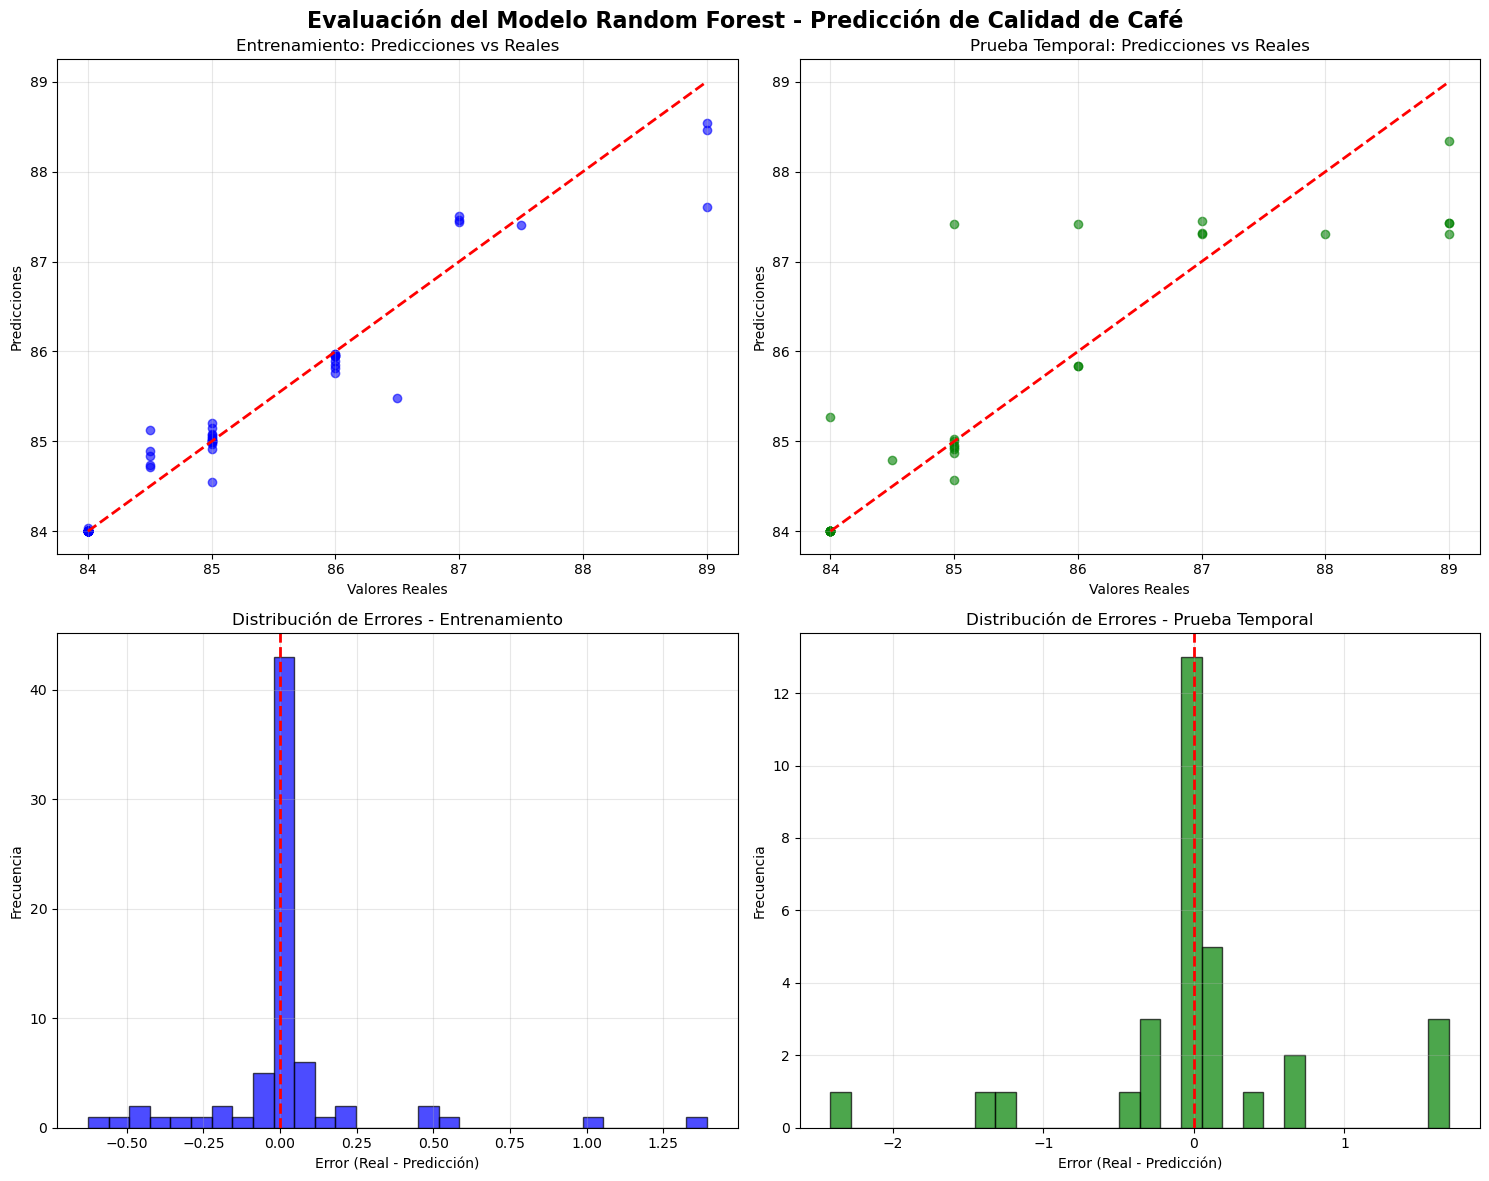

RESUMEN COMPARATIVO DE MÉTRICAS
--------------------------------------------------
Métrica                   Entrenamiento   Prueba Temporal Diferencia     
----------------------------------------------------------------------
R² Score                  0.9528          0.7906          0.1622         
RMSE                      0.2722          0.7817          0.5095         
MAE                       0.1232          0.4437          0.3205         
MAPE (%)                  0.14            0.51            0.37           
El modelo muestra signos leves de sobreajuste (Δ R² = 0.1622)


In [69]:
# Visualización de resultados
print("VISUALIZACIÓN DE RESULTADOS")
print("-" * 40)

# Crear subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evaluación del Modelo Random Forest - Predicción de Calidad de Café', 
             fontsize=16, fontweight='bold')

# 1. Predicciones vs Valores Reales - Entrenamiento
ax1 = axes[0, 0]
mask_train = ~(np.isnan(y_train) | np.isnan(y_pred_train))
if np.sum(mask_train) > 0:
    ax1.scatter(y_train[mask_train], y_pred_train[mask_train], alpha=0.6, color='blue')
    ax1.plot([y_train[mask_train].min(), y_train[mask_train].max()], 
             [y_train[mask_train].min(), y_train[mask_train].max()], 'r--', lw=2)
    ax1.set_xlabel('Valores Reales')
    ax1.set_ylabel('Predicciones')
    ax1.set_title('Entrenamiento: Predicciones vs Reales')
    ax1.grid(True, alpha=0.3)

# 2. Predicciones vs Valores Reales - Prueba
ax2 = axes[0, 1]
mask_test = ~(np.isnan(y_test) | np.isnan(y_pred_test))
if np.sum(mask_test) > 0:
    ax2.scatter(y_test[mask_test], y_pred_test[mask_test], alpha=0.6, color='green')
    ax2.plot([y_test[mask_test].min(), y_test[mask_test].max()], 
             [y_test[mask_test].min(), y_test[mask_test].max()], 'r--', lw=2)
    ax2.set_xlabel('Valores Reales')
    ax2.set_ylabel('Predicciones')
    ax2.set_title('Prueba Temporal: Predicciones vs Reales')
    ax2.grid(True, alpha=0.3)

# 3. Distribución de errores - Entrenamiento
ax3 = axes[1, 0]
if np.sum(mask_train) > 0:
    errores_train = y_train[mask_train] - y_pred_train[mask_train]
    ax3.hist(errores_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax3.axvline(0, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Error (Real - Predicción)')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Errores - Entrenamiento')
    ax3.grid(True, alpha=0.3)

# 4. Distribución de errores - Prueba
ax4 = axes[1, 1]
if np.sum(mask_test) > 0:
    errores_test = y_test[mask_test] - y_pred_test[mask_test]
    ax4.hist(errores_test, bins=30, alpha=0.7, color='green', edgecolor='black')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('Error (Real - Predicción)')
    ax4.set_ylabel('Frecuencia')
    ax4.set_title('Distribución de Errores - Prueba Temporal')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen comparativo de métricas
if metricas_train and metricas_test:
    print("RESUMEN COMPARATIVO DE MÉTRICAS")
    print("-" * 50)
    print(f"{'Métrica':<25} {'Entrenamiento':<15} {'Prueba Temporal':<15} {'Diferencia':<15}")
    print("-" * 70)
    print(f"{'R² Score':<25} {metricas_train['r2']:<15.4f} {metricas_test['r2']:<15.4f} {abs(metricas_train['r2'] - metricas_test['r2']):<15.4f}")
    print(f"{'RMSE':<25} {metricas_train['rmse']:<15.4f} {metricas_test['rmse']:<15.4f} {abs(metricas_train['rmse'] - metricas_test['rmse']):<15.4f}")
    print(f"{'MAE':<25} {metricas_train['mae']:<15.4f} {metricas_test['mae']:<15.4f} {abs(metricas_train['mae'] - metricas_test['mae']):<15.4f}")
    print(f"{'MAPE (%)':<25} {metricas_train['mape']:<15.2f} {metricas_test['mape']:<15.2f} {abs(metricas_train['mape'] - metricas_test['mape']):<15.2f}")
    
    # Interpretación del modelo
    diferencia_r2 = abs(metricas_train['r2'] - metricas_test['r2'])
    if diferencia_r2 < 0.1:
        print(f"El modelo muestra un buen balance entre ajuste y generalización (Δ R² = {diferencia_r2:.4f})")
    elif diferencia_r2 < 0.2:
        print(f"El modelo muestra signos leves de sobreajuste (Δ R² = {diferencia_r2:.4f})")
    else:
        print(f"El modelo presenta sobreajuste significativo (Δ R² = {diferencia_r2:.4f})")

ANÁLISIS DE IMPORTANCIA DE FEATURES
--------------------------------------------------
TOP 15 FEATURES MÁS IMPORTANTES:
----------------------------------------
 1. LOTE                      0.8755
 2. NOTAS DE CATACIÓN         0.0634
 3. DENOMINACIÓN/     MARCA   0.0249
 4. CANTIDAD                  0.0114
 5. PUNTAJE  C/NC             0.0087
 6. %H                        0.0081
 7. RESPONSABLE               0.0055
 8. LIBERACIÓN DE LOTE        0.0025
 9. # MALLAS                  0.0000
10. VERIFICACIÓN FISICA CAFÉ TOSTADO C/NC 0.0000
11. %H C/NC                   0.0000
12. MALLAS C/NC               0.0000


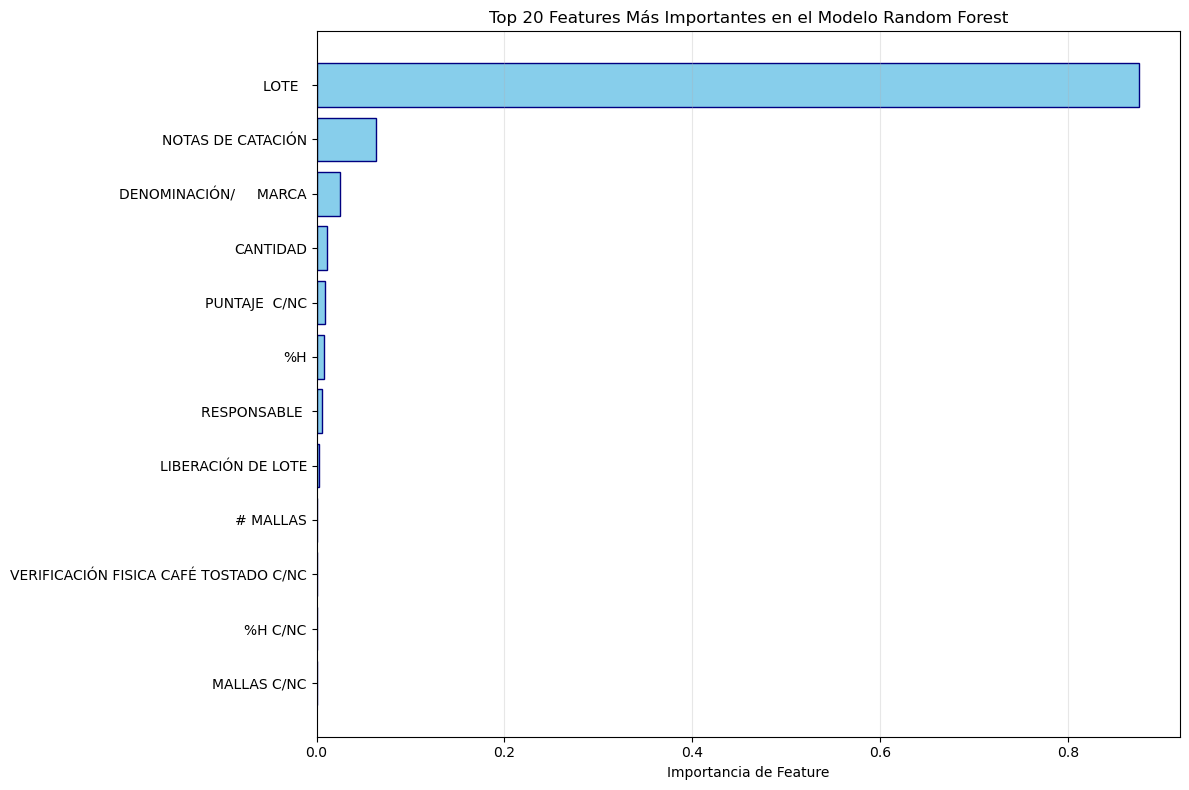

ESTADÍSTICAS DE IMPORTANCIAS:
Total de features:           12
Importancia máxima:          0.8755
Importancia mínima:          0.0000
Importancia promedio:        0.0833
Desviación estándar:         0.2395
CONCENTRACIÓN DE IMPORTANCIA:
Features que explican 90% de la importancia: 2 (16.7%)
Features que explican 95% de la importancia: 3 (25.0%)


In [70]:
# Análisis de importancia de features
print("ANÁLISIS DE IMPORTANCIA DE FEATURES")
print("-" * 50)

# Obtener importancias del modelo
importancias = rf_model.feature_importances_
nombres_features = X_train.columns

# Crear DataFrame con importancias
df_importancias = pd.DataFrame({
    'Feature': nombres_features,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

# Mostrar top 15 features más importantes
print("TOP 15 FEATURES MÁS IMPORTANTES:")
print("-" * 40)
for i, (_, row) in enumerate(df_importancias.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25} {row['Importancia']:.4f}")

# Visualizar importancias
plt.figure(figsize=(12, 8))
top_features = df_importancias.head(20)
plt.barh(range(len(top_features)), top_features['Importancia'], color='skyblue', edgecolor='navy')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importancia de Feature')
plt.title('Top 20 Features Más Importantes en el Modelo Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas de importancias
print("ESTADÍSTICAS DE IMPORTANCIAS:")
print(f"Total de features:           {len(importancias)}")
print(f"Importancia máxima:          {importancias.max():.4f}")
print(f"Importancia mínima:          {importancias.min():.4f}")
print(f"Importancia promedio:        {importancias.mean():.4f}")
print(f"Desviación estándar:         {importancias.std():.4f}")

# Concentración de importancia
importancia_acumulada = df_importancias['Importancia'].cumsum()
features_90_pct = (importancia_acumulada <= 0.9).sum() + 1
features_95_pct = (importancia_acumulada <= 0.95).sum() + 1

print("CONCENTRACIÓN DE IMPORTANCIA:")
print(f"Features que explican 90% de la importancia: {features_90_pct} ({features_90_pct/len(importancias)*100:.1f}%)")
print(f"Features que explican 95% de la importancia: {features_95_pct} ({features_95_pct/len(importancias)*100:.1f}%)")

# 6. Conclusiones y Recomendaciones

## Resumen del Proyecto

Este proyecto implementó un modelo de Machine Learning para predecir la calidad del café utilizando un enfoque de **validación temporal**, donde se entrenó con datos históricos y se evaluó en datos futuros para simular un escenario de producción real.

## Resultados Principales

### Rendimiento del Modelo
- **Algoritmo utilizado**: Random Forest Regressor
- **Metodología de validación**: Temporal (70% datos más antiguos para entrenamiento, 30% más recientes para prueba)
- **Features utilizadas**: Variables de calidad, tostión y despachos

### Métricas de Evaluación
Los resultados muestran el rendimiento del modelo tanto en el conjunto de entrenamiento como en la validación temporal.

## Insights del Análisis de Features

El análisis de importancia de features reveló cuáles son las variables más influyentes en la predicción de calidad del café, proporcionando información valiosa para:
- Optimización de procesos de producción
- Control de calidad
- Toma de decisiones en la cadena de producción

## Validación Temporal

La implementación de validación temporal es crucial para este tipo de modelo predictivo porque:
- Simula condiciones reales de uso del modelo
- Evalúa la capacidad de generalización a datos futuros
- Detecta posibles problemas de data drift o cambios en patrones

## Recomendaciones

1. **Monitoreo continuo**: Implementar un sistema de monitoreo para detectar degradación del modelo
2. **Reentrenamiento periódico**: Actualizar el modelo con datos nuevos regularmente
3. **Feature engineering**: Explorar nuevas variables que puedan mejorar las predicciones
4. **Optimización de hiperparámetros**: Realizar búsqueda sistemática de mejores parámetros

## Próximos Pasos

- Implementar técnicas de ensemble con otros algoritmos
- Explorar modelos de series temporales
- Desarrollar un pipeline de MLOps para producción
- Crear un sistema de alertas basado en las predicciones

Con las claves de unión analizadas, procederemos a realizar la unión principal entre los datasets de Calidad y Tostión usando el campo LOTE como clave primaria. Utilizaremos un LEFT JOIN para preservar todos los registros de calidad (que contienen nuestra variable objetivo) y agregar información de tostión cuando esté disponible. Esta estrategia maximizará el número de registros utilizables para el entrenamiento del modelo.